<a href="https://colab.research.google.com/github/ougrid/my-knowledge-resource/blob/master/M5_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

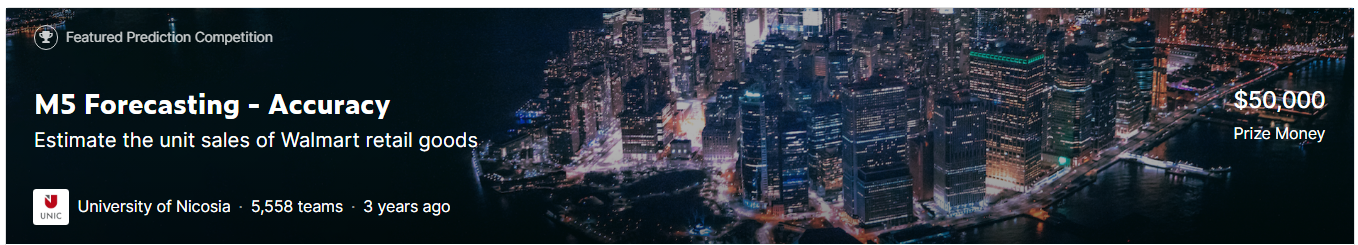

**This kernel has been created to test assignments for Coraline**

-----


Choose any problem on a link below that can represent your skill in Data science by following the CRISP-DM process.
https://www.kaggle.com/c/m5-forecasting-accuracy

What we are looking to evaluate:
1. Business Understanding and Problem Formulation
2. Data Understanding / EDA process
3. Modeling: Model / Feature selection
4. Model Evaluation
5. Business Impact / Insights

-----
Presented by Konthee Boonmeeprekob

# **Prepair notebook**

In [ ]:
#check GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
#Check version Python
!python --version

Python 3.10.12


## **Mouth Google Drive**

In [ ]:
# #Mouth my Google Drive to workspace
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## **Download Dataset from Kaggle**

In [ ]:
from google.colab import userdata
username = userdata.get('KAGGLE_USER')
key = userdata.get('KAGGLE_KEY')
# Echo the credentials into the kaggle.json file
!mkdir -p ~/.kaggle
!echo '{{"username":"{username}","key":"{key}"}}' > ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets list
!kaggle competitions download -c m5-forecasting-accuracy #download competition dataset

ref                                                              title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
jainaru/world-happiness-report-2024-yearly-updated               World Happiness Report- 2024                       62KB  2024-05-15 19:04:34           1582         32  1.0              
rahulvyasm/netflix-movies-and-tv-shows                           Netflix Movies and TV Shows                         1MB  2024-04-10 09:48:38          20968        463  1.0              
sahirmaharajj/school-student-daily-attendance                    School Student Daily Attendance                     2MB  2024-04-29 19:29:56           5461        114  1.0              
keremabdullahoglu/laptop-price-dataset-april-2024                

In [ ]:
# unzip file which download from kaggle
path_zip = '/content/m5-forecasting-accuracy.zip'
!unzip {path_zip}
!rm {path_zip}

Archive:  /content/m5-forecasting-accuracy.zip
  inflating: calendar.csv            
  inflating: sales_train_evaluation.csv  
  inflating: sales_train_validation.csv  
  inflating: sample_submission.csv   
  inflating: sell_prices.csv         


## **Import Library**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbs

from  datetime import datetime, timedelta
from tqdm.notebook import tqdm,trange
import lightgbm as lgb

import os, warnings
warnings.filterwarnings('ignore')

In [ ]:
# set display show
pd.options.display.max_columns = 50

# Data Understanding / **EDA** process

In [ ]:
df_calendar = pd.read_csv('/content/calendar.csv')
df_sales=pd.read_csv('/content/sales_train_evaluation.csv')

df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 452.9+ MB


### **Downcasting**

#### In this section I'll be downcasting the dataframes to reduce the amount of storage used by them and also to expidite the operations performed on them.



* **Numerical Columns**: Depending on your environment, pandas automatically creates int32, int64, float32 or float64 columns for numeric ones. If you know the min or max value of a column, you can use a subtype which is less memory consuming. You can also use an unsigned subtype if there is no negative value.
    Here are the different subtypes you can use:

    int8 / uint8 : consumes 1 byte of memory, range between -128/127 or 0/255

    bool : consumes 1 byte, true or false

    float16 / int16 / uint16: consumes 2 bytes of memory, range between -32768 and 32767 or 0/65535

    float32 / int32 / uint32 : consumes 4 bytes of memory, range between -2147483648 and 2147483647

    float64 / int64 / uint64: consumes 8 bytes of memory

    If one of your column has values between 1 and 10 for example, you will reduce the size of that column from 8 bytes per row to 1 byte, which is more than 85% memory saving on that column!
* **Categorical Columns**: Pandas stores categorical columns as objects. One of the reason this storage is not optimal is that it creates a list of pointers to the memory address of each value of your column. For columns with low cardinality (the amount of unique values is lower than 50% of the count of these values), this can be optimized by forcing pandas to use a virtual mapping table where all unique values are mapped via an integer instead of a pointer. This is done using the category datatype.

In [ ]:
#We are now first reducing the size of our df, by changing the datatype from object.
#Reference: https://www.kaggle.com/code/anshuls235/time-series-forecasting-eda-fe-modelling/notebook
#Downcast in order to save memory
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2

    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
df_sales = reduce_mem_usage(df_sales)
print(df_sales.info())
df_sales

# memory usage: 452.9+ MB ---> memory usage: 96.3 MB

Memory usage after optimization is: 96.13 MB
Decreased by 78.8%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int16(1317), int8(624), object(6)
memory usage: 96.1+ MB
None


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,0,3,1,4,1,0,0,3,4,4,0,0,1,0,1,...,2,2,0,0,0,2,0,0,1,1,1,0,0,1,0,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,5,0,1,1,3,1,1,0,4,2,0,1,2,1,...,1,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,2,4,1,8,5,2,7,5,3,5,20,8,10,3,3,...,1,0,2,1,1,0,0,1,0,0,1,0,3,3,1,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,1,0,2,1,1,2,0,2,1,1,0,2,1,1,1,1,4,6,0,1,1,1,0


----event_type_1----
cat_id
FOODS        14370
HOUSEHOLD    10470
HOBBIES       5650
Name: count, dtype: int64
----event_type_2----
store_id
CA_1    3049
CA_2    3049
CA_3    3049
CA_4    3049
TX_1    3049
TX_2    3049
TX_3    3049
WI_1    3049
WI_2    3049
WI_3    3049
Name: count, dtype: int64


<Axes: xlabel='cat_id'>

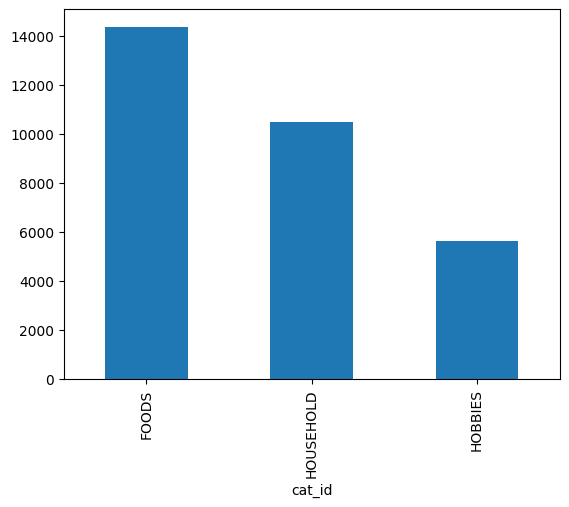

In [ ]:
print('----event_type_1----')
print(df_sales.cat_id.value_counts())
print('----event_type_2----')
print(df_sales.store_id.value_counts())
df_sales.cat_id.value_counts().plot(kind='bar')

In [ ]:
## ref https://www.kaggle.com/code/lebroschar/aggregate-forecast-eda/notebook
# Parameters
forecast_range = 28 # days

def plot_time_series(data):
    """Plot time series data."""
    fig, ax = plt.subplots()
    for ind in data.index:
        ax.plot([int(col.split('_')[-1]) for col in data.columns],
                data.loc[ind].values, '-', label=ind)
    ax.legend(loc='best')
    ax.set_xlabel('day number')
    ax.set_ylabel('items sold')


def plot_aggregation(data):
    """Make plots over two time periods."""
    plot_time_series(data)
    plot_time_series(data[data.columns[-3*28:]])

In [ ]:
cat_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','id']
ts_cols = [col for col in df_sales.columns if col not in cat_cols ]
ts_dict = {t: int(t[2:]) for t in ts_cols}

# Describe data
print('unique forecasts: %i' % df_sales.shape[0])
for col in cat_cols:
    print('  N_unique %s: %i' % (col, df_sales[col].nunique()))

unique forecasts: 30490
  N_unique item_id: 3049
  N_unique dept_id: 7
  N_unique cat_id: 3
  N_unique store_id: 10
  N_unique state_id: 3
  N_unique id: 30490


## Plot visualization & Insight

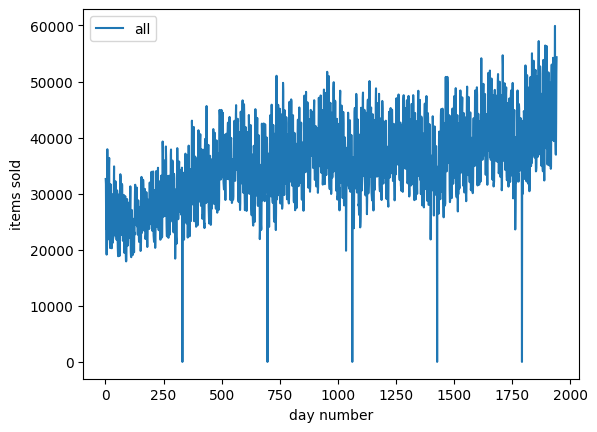

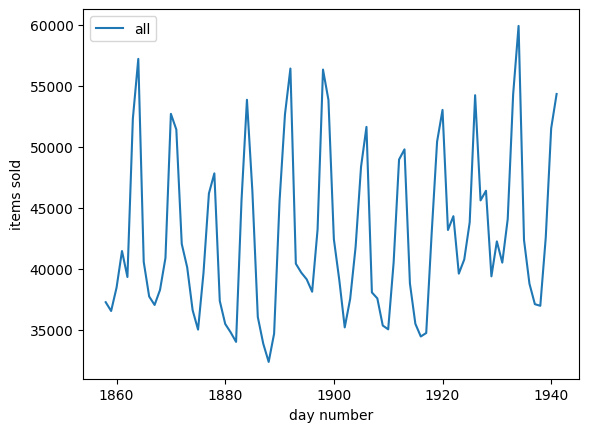

In [ ]:
# 1. All products, all stores, all states (1 series)
all_sales = pd.DataFrame(df_sales[ts_cols].sum(axis=0)).transpose()
all_sales.index = ['all']
plot_aggregation(all_sales)

**Insights:**
* Every year at christmas, the sales is "0" because Walmart is closed on that day.
* Here we can see that there is a growing trend in sales

In [ ]:
min_sell =[]
for col in ts_cols :
    x = df_sales[f'{col}'].sum()
    if x < 10000 :
        min_sell.append(col)

print(min_sell)

df_calendar.loc[(df_calendar['d']=='d_331') | (df_calendar['d']=='d_697')| (df_calendar['d']=='1062') | (df_calendar['d']=='d_1427') | (df_calendar['d']=='d_1792')]   #show day which has sell equal 0

['d_331', 'd_697', 'd_1062', 'd_1427', 'd_1792']


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
330,2011-12-25,11148,Sunday,2,12,2011,d_331,Christmas,National,NaN,NaN,0,0,0
696,2012-12-25,11248,Tuesday,4,12,2012,d_697,Christmas,National,NaN,NaN,0,0,0
1426,2014-12-25,11447,Thursday,6,12,2014,d_1427,Christmas,National,NaN,NaN,0,0,0
1791,2015-12-25,11547,Friday,7,12,2015,d_1792,Christmas,National,NaN,NaN,0,0,0


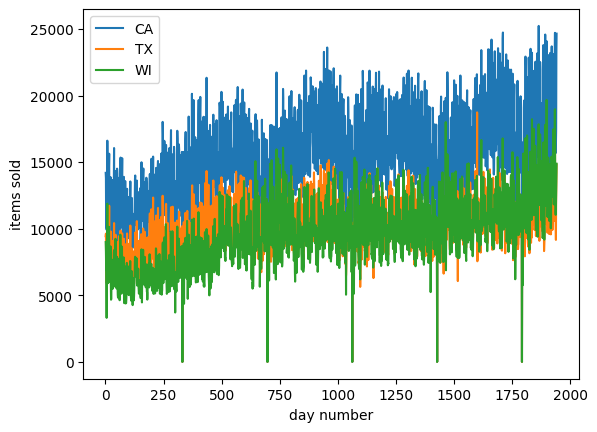

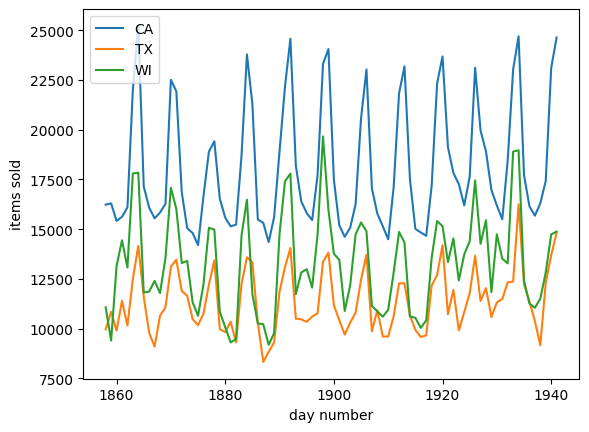

In [ ]:
# 2. All products by state (3 series)
state_sales = df_sales.groupby('state_id')[ts_cols].sum()
plot_aggregation(state_sales)

**Insights:**
* The stores in CA, sell more than any other state.
* The sales in TX was more than WI till 700 day, but after that the sales of "WI" have started growing and are the state with second highest sales from 2013.

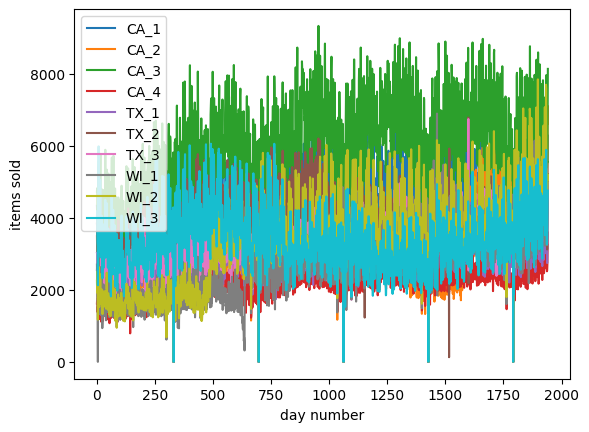

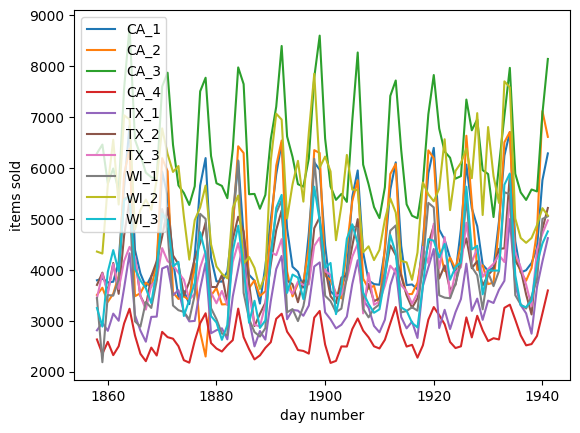

In [ ]:
# 3. All products by store (10 series)
store_sales = df_sales.groupby('store_id')[ts_cols].sum()
plot_aggregation(store_sales)

**Insights:**

**The sales of all the stores is overlapping, hence plotting for each state separately and understanding whats happening at each store.**
* The CA_3 is the best store with maximum sales & CA_4 is the store with the lowest sales, but as we can see the sales growth and changes are very different for each store, so we should better analyze them individually, to understand what is happening.
* Also a model at state level would be enough for our problem.

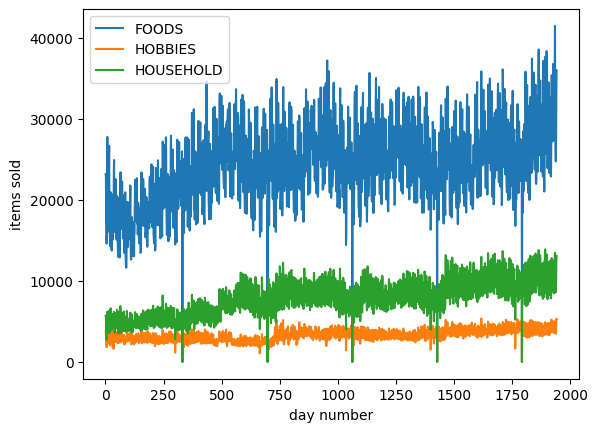

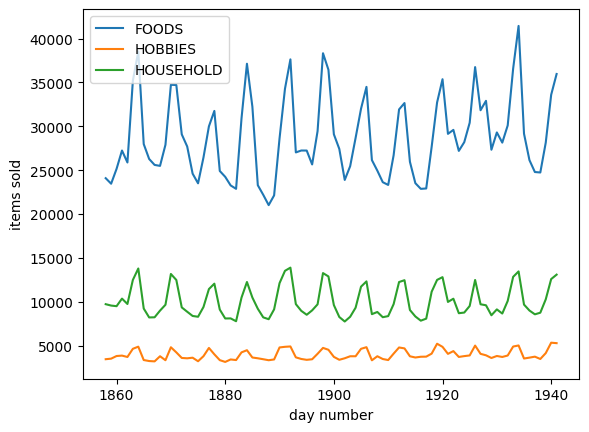

In [ ]:
# 4. All products by category (3 series)
cat_sales = df_sales.groupby('cat_id')[ts_cols].sum()
plot_aggregation(cat_sales)

 **Insights:**

*   Foods is the best store with maximum sales
*   Hobbies is the store with the lowest sales






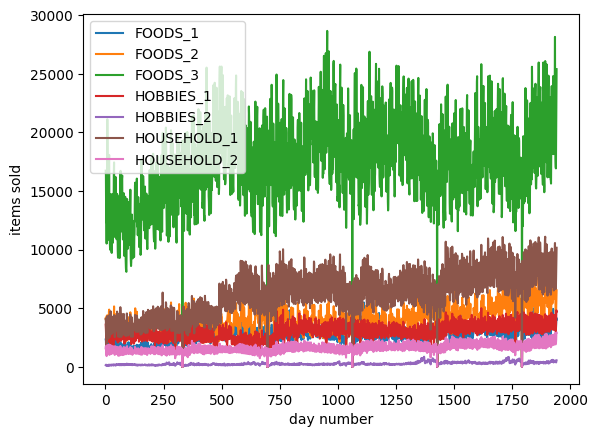

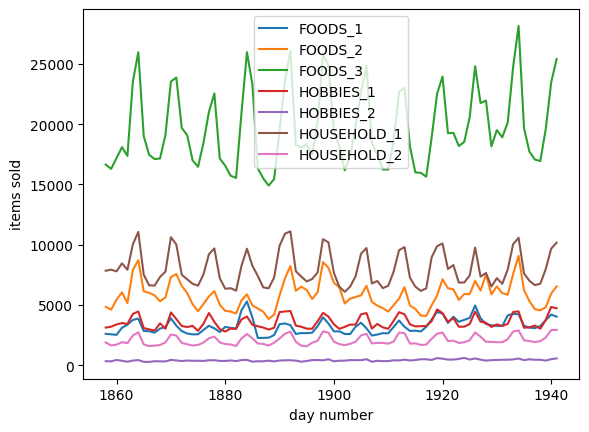

In [ ]:
# 5. All products by department (7 series)
dept_sales = df_sales.groupby('dept_id')[ts_cols].sum()
plot_aggregation(dept_sales)

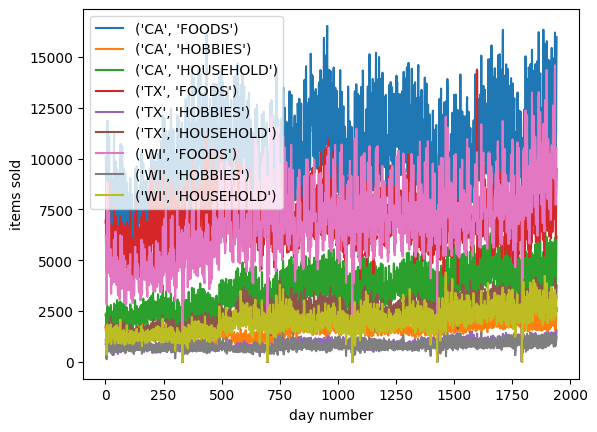

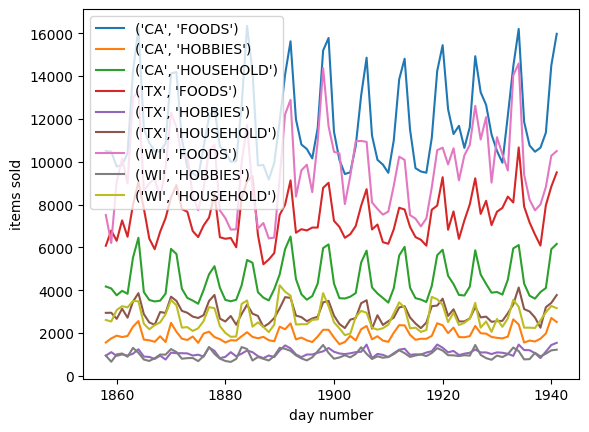

In [ ]:
# 6. All products by state and category (9 series)
state_cat_sales = df_sales.groupby(['state_id', 'cat_id'])[ts_cols].sum()
plot_aggregation(state_cat_sales)

# **Modeling: Model / Feature selection**

### **Preproces**

In [ ]:
CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category",
             "event_type_2": "category", "weekday": "category",
             'wm_yr_wk': 'int16', "wday": "int16","month": "int16", "year": "int16",
             "snap_CA": "float32",'snap_TX': 'float32', 'snap_WI': 'float32' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

In [ ]:
h = 28     # day forecast_range
max_lags = 70
tr_last = 1913
fday = datetime(2016,4, 25)
print(fday)
df_calendar.loc[(df_calendar['d']=='d_1914')]

2016-04-25 00:00:00


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1913,2016-04-25,11613,Monday,3,4,2016,d_1914,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
# clear memmory
del df_calendar
del df_sales

In [ ]:
# create function to transform and merge data to one Tabel
def create_df(trainning = True, first_day = 1200):
    df_prices = pd.read_csv("/content/sell_prices.csv", dtype = PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            df_prices[col] = df_prices[col].cat.codes.astype("int16")
            df_prices[col] -= df_prices[col].min()

    df_cal = pd.read_csv("/content/calendar.csv", dtype = CAL_DTYPES)
    df_cal["date"] = pd.to_datetime(df_cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            df_cal[col] = df_cal[col].cat.codes.astype("int16")
            df_cal[col] -= df_cal[col].min()

    start_day = max(1 if trainning  else tr_last-max_lags, first_day)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols}
    dtype.update({col: "category" for col in catcols if col != "id"})

    df = pd.read_csv("/content/sales_train_validation.csv",
                    usecols = catcols + numcols, dtype = dtype)

    for col in catcols:
        if col != "id":
            df[col] = df[col].cat.codes.astype("int16")
            df[col] -= df[col].min()

    if not trainning:
        for day in range(tr_last+1, tr_last+ 28 +1):
            df[f"d_{day}"] = np.nan

    df = pd.melt(df,
                  id_vars = catcols,
                  value_vars = [col for col in df.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")

    df = df.merge(df_cal, on= "d", copy = False)
    df = df.merge(df_prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)

    return df

In [ ]:
%%time
FIRST_DAY = 1000
df = create_df(trainning=True, first_day= FIRST_DAY)
print(df.shape)
df

(26600086, 22)
CPU times: user 22.9 s, sys: 12.2 s, total: 35 s
Wall time: 35.5 s


,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1000,0.0,2013-10-24,11339,4,6,10,2013,0,0,0,0,0.0,0.0,0.0,8.26
1,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1001,2.0,2013-10-25,11339,0,7,10,2013,0,0,0,0,0.0,0.0,0.0,8.26
2,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_1000,0.0,2013-10-24,11339,4,6,10,2013,0,0,0,0,0.0,0.0,0.0,3.97
3,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_1001,0.0,2013-10-25,11339,0,7,10,2013,0,0,0,0,0.0,0.0,0.0,3.97
4,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,d_1000,1.0,2013-10-24,11339,4,6,10,2013,0,0,0,0,0.0,0.0,0.0,4.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26600081,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.98
26600082,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1912,1.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.28
26600083,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1913,3.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.28
26600084,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1912,0.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.00


In [ ]:
# create function to extract feature (lag and window average laging)
def create_fea(df):
    lags = [7,14,28]
    lag_cols = [f"lag_{lag}" for lag in lags]
    for lag, lag_col in (zip(lags, lag_cols)):
        df[lag_col] = df[["id","sales"]].groupby("id")["sales"].shift(lag)

    wins = [7,28]
    for win in (wins) :
        for lag,lag_col in (zip(lags, lag_cols)):
            df[f"rmean_{lag}_{win}"] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())


    date_features = {

        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
    }

#     dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)

    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in df.columns:
            df[date_feat_name] = df[date_feat_name].astype("int16")
        else:
            df[date_feat_name] = getattr(df["date"].dt, date_feat_func).astype("int16")

In [ ]:
%%time

create_fea(df)
print(df.shape)
df

(26600086, 34)
CPU times: user 2min 48s, sys: 15.4 s, total: 3min 3s
Wall time: 3min 11s


,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_14,lag_28,rmean_7_7,rmean_14_7,rmean_28_7,rmean_7_28,rmean_14_28,rmean_28_28,week,quarter,mday
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1000,0.0,2013-10-24,11339,4,6,10,2013,0,0,0,0,0.0,0.0,0.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43,4,24
1,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1001,2.0,2013-10-25,11339,0,7,10,2013,0,0,0,0,0.0,0.0,0.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43,4,25
2,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_1000,0.0,2013-10-24,11339,4,6,10,2013,0,0,0,0,0.0,0.0,0.0,3.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43,4,24
3,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_1001,0.0,2013-10-25,11339,0,7,10,2013,0,0,0,0,0.0,0.0,0.0,3.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43,4,25
4,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,d_1000,1.0,2013-10-24,11339,4,6,10,2013,0,0,0,0,0.0,0.0,0.0,4.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43,4,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26600081,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.98,0.0,2.0,1.0,1.000000,1.571429,0.714286,0.928571,0.928571,1.250000,16,2,24
26600082,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1912,1.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,0.0,1.0,2.0,0.857143,1.142857,1.142857,1.035714,1.178571,1.107143,16,2,23
26600083,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1913,3.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,1.0,2.0,4.0,0.714286,1.285714,1.571429,1.035714,1.142857,1.250000,16,2,24
26600084,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1912,0.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.00,0.0,1.0,0.0,0.000000,1.285714,2.285714,1.821429,2.357143,1.785714,16,2,23


## Clean data

In [ ]:
# (remove null)
df.dropna(inplace = True)
df.shape

(24923136, 34)

In [ ]:
df=downcast(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24923136 entries, 1309472 to 26600085
Data columns (total 34 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       int16         
 2   dept_id       int8          
 3   store_id      int8          
 4   cat_id        int8          
 5   state_id      int8          
 6   d             category      
 7   sales         float16       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int8          
 11  wday          int8          
 12  month         int8          
 13  year          int16         
 14  event_name_1  int8          
 15  event_type_1  int8          
 16  event_name_2  int8          
 17  event_type_2  int8          
 18  snap_CA       float16       
 19  snap_TX       float16       
 20  snap_WI       float16       
 21  sell_price    float16       
 22  lag_7         float16       
 23  lag_14        float16   

In [ ]:
df.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_14,lag_28,rmean_7_7,rmean_14_7,rmean_28_7,rmean_7_28,rmean_14_28,rmean_28_28,week,quarter,mday
1309472,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1055,1.0,2013-12-18,11347,6,5,12,2013,0,0,0,0,0.0,0.0,0.0,8.257812,0.0,1.0,0.0,0.571289,1.000000,0.142822,0.535645,0.714355,0.714355,51,4,18
1309473,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1056,2.0,2013-12-19,11347,4,6,12,2013,0,0,0,0,0.0,0.0,0.0,8.257812,3.0,0.0,0.0,1.000000,0.856934,0.142822,0.643066,0.678711,0.714355,51,4,19
1309474,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1057,0.0,2013-12-20,11347,0,7,12,2013,0,0,0,0,0.0,0.0,0.0,8.257812,0.0,1.0,0.0,0.856934,0.856934,0.142822,0.643066,0.678711,0.643066,51,4,20
1309479,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_1055,1.0,2013-12-18,11347,6,5,12,2013,0,0,0,0,0.0,0.0,0.0,3.970703,0.0,0.0,0.0,0.428467,0.000000,0.285645,0.178589,0.071411,0.142822,51,4,18
1309480,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_1056,0.0,2013-12-19,11347,4,6,12,2013,0,0,0,0,0.0,0.0,0.0,3.970703,0.0,0.0,0.0,0.428467,0.000000,0.285645,0.178589,0.071411,0.142822,51,4,19


## **Feature Selection**

In [ ]:
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
train_cols = df.columns[~df.columns.isin(useless_cols)]
X_train = df[train_cols]
y_train = df["sales"]

## **Model Building** (LightGBM)


In [ ]:
train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=cat_feats, free_raw_data=False)
fake_valid_inds = np.random.choice(len(X_train), 1000000)
fake_valid_data = lgb.Dataset(X_train.iloc[fake_valid_inds], label = y_train.iloc[fake_valid_inds],categorical_feature=cat_feats,
                             free_raw_data=False)   # This is just a subsample of the training set, not a real validation set !


#### **Set parameter for lgb**

In [ ]:
params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        "metric": ["rmse"],
        'verbosity': 1,
        'num_iterations' : 500,

}

#### **Train model**

In [ ]:
%%time

m_lgb = lgb.train(params, train_data, valid_sets = [fake_valid_data], verbose_eval=50)

[LightGBM] [Info] Total Bins 5203
[LightGBM] [Info] Number of data points in the train set: 24923136, number of used features: 28
[LightGBM] [Info] Start training from score 0.240079
[50]	valid_0's rmse: 2.27293
[100]	valid_0's rmse: 2.22124
[150]	valid_0's rmse: 2.20905
[200]	valid_0's rmse: 2.19292
[250]	valid_0's rmse: 2.18203
[300]	valid_0's rmse: 2.17376
[350]	valid_0's rmse: 2.16347
[400]	valid_0's rmse: 2.15561
[450]	valid_0's rmse: 2.14928
[500]	valid_0's rmse: 2.14158
CPU times: user 52min 27s, sys: 10.4 s, total: 52min 38s
Wall time: 31min 50s


In [ ]:
m_lgb.save_model("model.lgb")

#  **Model Evaluation**

## Forecast d_1914 - d_1941 (normal)


In [ ]:
%%time

alphas = [1]
weights = [1/len(alphas)]*len(alphas)
sub = 0.

for icount, (alpha, weight) in enumerate(zip(alphas, weights)):

    te = create_df(False)
    cols = [f"F{i}" for i in range(1,29)]

    for tdelta in trange(0, 28):
#     for tdelta in range(0, 2):
        day = fday + timedelta(days=tdelta)
        print(icount, day)
        tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
        create_fea(tst)
        tst = tst.loc[tst.date == day , train_cols]
        te.loc[te.date == day, "sales"] = alpha*m_lgb.predict(tst) # magic multiplier by kyakovlev



    te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()
#     te_sub.loc[te.date >= fday+ timedelta(days=h), "id"] = te_sub.loc[te.date >= fday+timedelta(days=h),
#                                                                           "id"].str.replace("validation$", "evaluation")
    te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
    te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
    te_sub.fillna(0., inplace = True)
    te_sub.sort_values("id", inplace = True)
    te_sub.reset_index(drop=True, inplace = True)
#     te_sub.to_csv("submission.csv",index=False)
    if icount == 0 :
        sub = te_sub
        sub[cols] *= weight
    else:
        sub[cols] += te_sub[cols]*weight
    print(icount, alpha, weight)


sub2 = sub.copy()
sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
sub = pd.concat([sub, sub2], axis=0, sort=False)
sub.to_csv("submission.csv",index=False)

  0%|          | 0/28 [00:00<?, ?it/s]

0 2016-04-25 00:00:00
0 2016-04-26 00:00:00
0 2016-04-27 00:00:00
0 2016-04-28 00:00:00
0 2016-04-29 00:00:00
0 2016-04-30 00:00:00
0 2016-05-01 00:00:00
0 2016-05-02 00:00:00
0 2016-05-03 00:00:00
0 2016-05-04 00:00:00
0 2016-05-05 00:00:00
0 2016-05-06 00:00:00
0 2016-05-07 00:00:00
0 2016-05-08 00:00:00
0 2016-05-09 00:00:00
0 2016-05-10 00:00:00
0 2016-05-11 00:00:00
0 2016-05-12 00:00:00
0 2016-05-13 00:00:00
0 2016-05-14 00:00:00
0 2016-05-15 00:00:00
0 2016-05-16 00:00:00
0 2016-05-17 00:00:00
0 2016-05-18 00:00:00
0 2016-05-19 00:00:00
0 2016-05-20 00:00:00
0 2016-05-21 00:00:00
0 2016-05-22 00:00:00
0 1 1.0
CPU times: user 39min 11s, sys: 24 s, total: 39min 35s
Wall time: 39min 16s


In [ ]:
!kaggle competitions submit -c m5-forecasting-accuracy -f /content/submission.csv -m "Message"

100% 32.8M/32.8M [00:04<00:00, 7.16MB/s]
Successfully submitted to M5 Forecasting - Accuracy

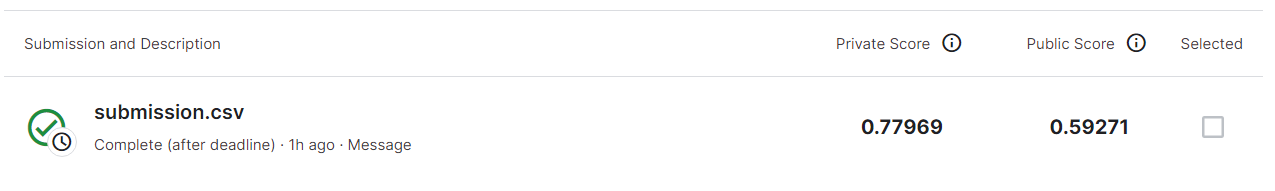

Predict only d_1914 - d_1941 for validation **(corresponding to the Public leaderboard)**

> Public Score 0.59271



In [ ]:
sub_0 = sub.copy()
sub_0


F,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,1.012010,0.917415,0.906115,0.867772,1.070515,1.329241,1.250604,1.062794,1.018258,1.009341,1.019384,1.081862,1.331909,1.173012,0.992539,0.936847,0.929310,0.926321,1.037852,1.304884,1.253217,0.989643,0.922256,0.896525,0.889015,1.010808,1.241521,1.241797
1,FOODS_1_001_CA_2_validation,1.221890,1.257522,1.182248,1.482795,1.449931,1.805047,1.901446,1.000707,0.975904,0.976680,0.987818,1.160273,1.592853,1.442125,1.108828,1.046636,1.061028,1.039598,1.179905,1.761413,1.531563,1.091678,1.047893,1.028751,1.074234,1.240893,1.724341,1.512636
2,FOODS_1_001_CA_3_validation,1.140405,1.074074,1.034031,1.037859,1.077542,1.310288,1.071519,0.904027,0.995287,0.949927,0.968116,1.029428,1.296144,1.186242,1.078136,1.060896,1.059279,1.073173,1.106334,1.337115,1.312838,1.069178,1.050178,1.037737,1.030846,1.102763,1.316960,1.134814
3,FOODS_1_001_CA_4_validation,0.373671,0.342851,0.324531,0.324329,0.387404,0.438645,0.484145,0.357780,0.380182,0.370263,0.367741,0.395928,0.414654,0.384648,0.354453,0.348998,0.387451,0.387451,0.431192,0.455187,0.463798,0.373057,0.360746,0.358184,0.371882,0.406264,0.482890,0.478773
4,FOODS_1_001_TX_1_validation,0.203061,0.186734,0.163491,0.163390,0.177274,0.199747,0.199133,0.288762,0.291956,0.278561,0.281612,0.296721,0.306655,0.268372,0.282977,0.286978,0.338386,0.337690,0.363505,0.363263,0.347756,0.288893,0.279889,0.276937,0.268027,0.292512,0.316484,0.316649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_evaluation,0.259517,0.243594,0.271999,0.254696,0.264451,0.322214,0.325048,0.245780,0.272562,0.249912,0.232124,0.251276,0.308297,0.274226,0.254304,0.237650,0.250263,0.248315,0.250573,0.333437,0.324285,0.235734,0.228471,0.247696,0.240792,0.250636,0.293511,0.285167
30486,HOUSEHOLD_2_516_TX_3_evaluation,0.148406,0.139766,0.144141,0.139546,0.150397,0.156565,0.161082,0.150942,0.151798,0.135731,0.144631,0.154719,0.172977,0.149808,0.153630,0.137474,0.129390,0.138034,0.144423,0.159055,0.159697,0.139983,0.130369,0.131337,0.132052,0.140068,0.150962,0.150858
30487,HOUSEHOLD_2_516_WI_1_evaluation,0.101296,0.099400,0.099484,0.099422,0.095462,0.106390,0.107567,0.109957,0.109266,0.107233,0.107145,0.121640,0.148459,0.124948,0.116932,0.113644,0.114885,0.114885,0.124964,0.148309,0.149636,0.115630,0.113408,0.113408,0.113331,0.128428,0.151310,0.153501
30488,HOUSEHOLD_2_516_WI_2_evaluation,0.055527,0.054744,0.054790,0.114777,0.111788,0.114597,0.120437,0.123203,0.125913,0.118132,0.116138,0.121942,0.134056,0.115551,0.123674,0.122596,0.123340,0.123340,0.130773,0.139208,0.138712,0.125705,0.124846,0.124846,0.113288,0.120824,0.128202,0.127984


## **Forecast d_1914 - d_1941 (Magic multiplier by kyakovlev)**

In [ ]:
%%time

alphas = [1.035, 1.03, 1.025, 1.02]
weights = [1/len(alphas)]*len(alphas)
sub = 0.

for icount, (alpha, weight) in enumerate(zip(alphas, weights)):

    te = create_df(False)
    cols = [f"F{i}" for i in range(1,29)]

    for tdelta in trange(0, 28):
#     for tdelta in range(0, 2):
        day = fday + timedelta(days=tdelta)
        print(icount, day)
        tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
        create_fea(tst)
        tst = tst.loc[tst.date == day , train_cols]
        te.loc[te.date == day, "sales"] = alpha*m_lgb.predict(tst) # magic multiplier by kyakovlev



    te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()
#     te_sub.loc[te.date >= fday+ timedelta(days=h), "id"] = te_sub.loc[te.date >= fday+timedelta(days=h),
#                                                                           "id"].str.replace("validation$", "evaluation")
    te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
    te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
    te_sub.fillna(0., inplace = True)
    te_sub.sort_values("id", inplace = True)
    te_sub.reset_index(drop=True, inplace = True)
#     te_sub.to_csv("submission.csv",index=False)
    if icount == 0 :
        sub = te_sub
        sub[cols] *= weight
    else:
        sub[cols] += te_sub[cols]*weight
    print(icount, alpha, weight)


sub2 = sub.copy()
sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
sub = pd.concat([sub, sub2], axis=0, sort=False)
sub.to_csv("submission_magic.csv",index=False)

  0%|          | 0/28 [00:00<?, ?it/s]

0 2016-04-25 00:00:00
0 2016-04-26 00:00:00
0 2016-04-27 00:00:00
0 2016-04-28 00:00:00
0 2016-04-29 00:00:00
0 2016-04-30 00:00:00
0 2016-05-01 00:00:00
0 2016-05-02 00:00:00
0 2016-05-03 00:00:00
0 2016-05-04 00:00:00
0 2016-05-05 00:00:00
0 2016-05-06 00:00:00
0 2016-05-07 00:00:00
0 2016-05-08 00:00:00
0 2016-05-09 00:00:00
0 2016-05-10 00:00:00
0 2016-05-11 00:00:00
0 2016-05-12 00:00:00
0 2016-05-13 00:00:00
0 2016-05-14 00:00:00
0 2016-05-15 00:00:00
0 2016-05-16 00:00:00
0 2016-05-17 00:00:00
0 2016-05-18 00:00:00
0 2016-05-19 00:00:00
0 2016-05-20 00:00:00
0 2016-05-21 00:00:00
0 2016-05-22 00:00:00
0 1.035 0.25


  0%|          | 0/28 [00:00<?, ?it/s]

1 2016-04-25 00:00:00
1 2016-04-26 00:00:00
1 2016-04-27 00:00:00
1 2016-04-28 00:00:00
1 2016-04-29 00:00:00
1 2016-04-30 00:00:00
1 2016-05-01 00:00:00
1 2016-05-02 00:00:00
1 2016-05-03 00:00:00
1 2016-05-04 00:00:00
1 2016-05-05 00:00:00
1 2016-05-06 00:00:00
1 2016-05-07 00:00:00
1 2016-05-08 00:00:00
1 2016-05-09 00:00:00
1 2016-05-10 00:00:00
1 2016-05-11 00:00:00
1 2016-05-12 00:00:00
1 2016-05-13 00:00:00
1 2016-05-14 00:00:00
1 2016-05-15 00:00:00
1 2016-05-16 00:00:00
1 2016-05-17 00:00:00
1 2016-05-18 00:00:00
1 2016-05-19 00:00:00
1 2016-05-20 00:00:00
1 2016-05-21 00:00:00
1 2016-05-22 00:00:00
1 1.03 0.25


  0%|          | 0/28 [00:00<?, ?it/s]

2 2016-04-25 00:00:00
2 2016-04-26 00:00:00
2 2016-04-27 00:00:00
2 2016-04-28 00:00:00
2 2016-04-29 00:00:00
2 2016-04-30 00:00:00
2 2016-05-01 00:00:00
2 2016-05-02 00:00:00
2 2016-05-03 00:00:00
2 2016-05-04 00:00:00
2 2016-05-05 00:00:00
2 2016-05-06 00:00:00
2 2016-05-07 00:00:00
2 2016-05-08 00:00:00
2 2016-05-09 00:00:00
2 2016-05-10 00:00:00
2 2016-05-11 00:00:00
2 2016-05-12 00:00:00
2 2016-05-13 00:00:00
2 2016-05-14 00:00:00
2 2016-05-15 00:00:00
2 2016-05-16 00:00:00
2 2016-05-17 00:00:00
2 2016-05-18 00:00:00
2 2016-05-19 00:00:00
2 2016-05-20 00:00:00
2 2016-05-21 00:00:00
2 2016-05-22 00:00:00
2 1.025 0.25


  0%|          | 0/28 [00:00<?, ?it/s]

3 2016-04-25 00:00:00
3 2016-04-26 00:00:00
3 2016-04-27 00:00:00
3 2016-04-28 00:00:00
3 2016-04-29 00:00:00
3 2016-04-30 00:00:00
3 2016-05-01 00:00:00
3 2016-05-02 00:00:00
3 2016-05-03 00:00:00
3 2016-05-04 00:00:00
3 2016-05-05 00:00:00
3 2016-05-06 00:00:00
3 2016-05-07 00:00:00
3 2016-05-08 00:00:00
3 2016-05-09 00:00:00
3 2016-05-10 00:00:00
3 2016-05-11 00:00:00
3 2016-05-12 00:00:00
3 2016-05-13 00:00:00
3 2016-05-14 00:00:00
3 2016-05-15 00:00:00
3 2016-05-16 00:00:00
3 2016-05-17 00:00:00
3 2016-05-18 00:00:00
3 2016-05-19 00:00:00
3 2016-05-20 00:00:00
3 2016-05-21 00:00:00
3 2016-05-22 00:00:00
3 1.02 0.25
CPU times: user 2h 37min 29s, sys: 1min 27s, total: 2h 38min 56s
Wall time: 2h 38min 1s


In [ ]:
!kaggle competitions submit -c m5-forecasting-accuracy -f /content/submission_magic.csv -m "Magic multiplier by kyakovlev"

100% 32.7M/32.7M [00:04<00:00, 8.05MB/s]
Successfully submitted to M5 Forecasting - Accuracy

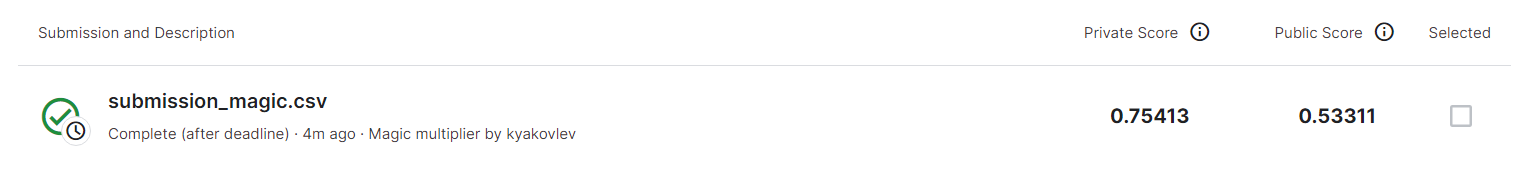

Predict only d_1914 - d_1941 for validation **(corresponding to the Public leaderboard)**

> Public Score 0.53311

# **Business Impact / Insights**

## Plot prediction

In [ ]:
sub.head()

F,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,1.039841,0.942644,0.931034,0.891636,1.099954,1.365795,1.284995,1.092021,1.046260,1.037098,1.047417,1.111613,1.368536,1.233445,1.039543,0.973755,0.974911,0.978657,1.066393,1.340769,1.296151,1.031278,0.953130,0.929388,0.924427,1.060736,1.310302,1.325772
1,FOODS_1_001_CA_2_validation,1.255492,1.292104,1.214760,1.523572,1.489804,1.854686,1.953736,1.028226,1.039269,1.003539,1.060682,1.209468,1.722358,1.541095,1.154270,1.089530,1.102083,1.115630,1.244743,1.815687,1.659496,1.140528,1.084772,1.075269,1.119700,1.300486,1.807189,1.628036
2,FOODS_1_001_CA_3_validation,1.171766,1.103611,1.062467,1.066400,1.107175,1.346321,1.100986,0.928887,1.022658,0.976050,0.994740,1.077485,1.331788,1.218864,1.107785,1.090661,1.088852,1.102835,1.137881,1.376732,1.374249,1.117728,1.096617,1.080260,1.078448,1.142767,1.357878,1.189143
3,FOODS_1_001_CA_4_validation,0.383947,0.352279,0.333456,0.333248,0.398058,0.450708,0.497459,0.367619,0.390637,0.380445,0.377854,0.406816,0.426057,0.395226,0.364200,0.366794,0.398106,0.398106,0.443049,0.467705,0.493070,0.383316,0.371174,0.384221,0.382109,0.422633,0.496169,0.500961
4,FOODS_1_001_TX_1_validation,0.208645,0.191869,0.167987,0.167883,0.182149,0.205240,0.204610,0.296703,0.299985,0.286222,0.289357,0.304880,0.315088,0.275753,0.290759,0.336712,0.347691,0.349124,0.373501,0.373253,0.357319,0.296838,0.288909,0.284553,0.276129,0.300556,0.326554,0.325357


In [ ]:
eval = pd.read_csv('/content/sales_train_evaluation.csv')
eval.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0


In [ ]:
df_val=pd.read_csv('/content/sales_train_validation.csv')

In [ ]:
#  fill predict into df_val
predict = df_val.copy()
predict = predict.merge(sub, on= "id", copy = False)
predict.head()



,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.911326,0.920325,1.242208,1.271123,0.988428,0.979929,0.921204,0.949569,1.021541,1.341938,1.104347,1.051120,0.931885,0.925155,0.890285,0.995694,1.267394,1.174318,0.912652,0.873483,0.860960,0.895973,0.993395,1.198112,1.217329
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.219663,0.235475,0.250221,0.264464,0.203882,0.204896,0.213581,0.194206,0.214243,0.230977,0.213853,0.210503,0.199689,0.202984,0.202604,0.241646,0.295077,0.253615,0.194348,0.192461,0.198623,0.187409,0.225415,0.282887,0.289416
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.460788,0.548470,0.763149,0.707325,0.522288,0.493280,0.489789,0.461741,0.552918,0.706024,0.611521,0.570197,0.535646,0.533968,0.514603,0.586840,0.742517,0.733292,0.568473,0.538680,0.546856,0.506550,0.569974,0.702560,0.673708
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1.490623,1.938076,2.829437,2.830506,2.009781,1.871139,1.772805,1.815692,2.131081,3.026986,2.380428,2.097854,1.850502,1.891938,1.914440,2.172496,2.961969,2.808445,1.977822,1.787046,1.745013,1.743216,2.097825,3.065541,2.834935
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1.015594,1.205332,1.523792,1.868173,1.356828,1.326278,1.185360,1.138177,1.293176,1.667831,1.312116,1.202841,1.086991,1.098067,1.122120,1.259955,1.689770,1.591384,1.144842,1.079827,1.074269,1.076080,1.219781,1.696325,1.694765


In [ ]:
# rename column to eval fotmat  [ F1-F28 ------> d_1914 - d_1941]
for i in trange(28):
    predict.rename(columns={f"{predict.columns[-28+i]}": f"d_{1914+i}"},inplace=True)

predict.head()

  0%|          | 0/28 [00:00<?, ?it/s]

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.911326,0.920325,1.242208,1.271123,0.988428,0.979929,0.921204,0.949569,1.021541,1.341938,1.104347,1.051120,0.931885,0.925155,0.890285,0.995694,1.267394,1.174318,0.912652,0.873483,0.860960,0.895973,0.993395,1.198112,1.217329
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.219663,0.235475,0.250221,0.264464,0.203882,0.204896,0.213581,0.194206,0.214243,0.230977,0.213853,0.210503,0.199689,0.202984,0.202604,0.241646,0.295077,0.253615,0.194348,0.192461,0.198623,0.187409,0.225415,0.282887,0.289416
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.460788,0.548470,0.763149,0.707325,0.522288,0.493280,0.489789,0.461741,0.552918,0.706024,0.611521,0.570197,0.535646,0.533968,0.514603,0.586840,0.742517,0.733292,0.568473,0.538680,0.546856,0.506550,0.569974,0.702560,0.673708
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1.490623,1.938076,2.829437,2.830506,2.009781,1.871139,1.772805,1.815692,2.131081,3.026986,2.380428,2.097854,1.850502,1.891938,1.914440,2.172496,2.961969,2.808445,1.977822,1.787046,1.745013,1.743216,2.097825,3.065541,2.834935
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1.015594,1.205332,1.523792,1.868173,1.356828,1.326278,1.185360,1.138177,1.293176,1.667831,1.312116,1.202841,1.086991,1.098067,1.122120,1.259955,1.689770,1.591384,1.144842,1.079827,1.074269,1.076080,1.219781,1.696325,1.694765


In [ ]:
cat_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','id']
ts_cols = [col for col in eval.columns if col not in cat_cols ]



In [ ]:
# cat_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','id']
# predict_cols = [col for col in predict.columns if col not in cat_cols ]


In [ ]:
forecast_range = 28 # days

def plot_time_series2(data,data2,predict_data):
    """Plot time series data."""
    fig, ax = plt.subplots()
    for ind in data.index:
        ax.plot([int(col.split('_')[-1]) for col in data.columns],
                data.loc[ind].values, '-', label=ind)
    for ind in data2.index:
        ax.plot([int(col.split('_')[-1]) for col in data2.columns],
                data2.loc[ind].values, '-', label=ind)

    for ind in predict_data.index:
        ax.plot([int(col.split('_')[-1]) for col in predict_data.columns],
                predict_data.loc[ind].values, '-', label=ind)
    ax.legend(loc='best')
    ax.set_xlabel('day number')
    ax.set_ylabel('items sold')


def plot_aggregation2(data,predict_data):
    """Make plots over two time periods."""
    plot_time_series2(data[data.columns[-5*28:-28]],data[data.columns[-28:]],predict_data[predict_data.columns[-28:]])
    # plot_time_series2(data[data.columns[-3*28:]])

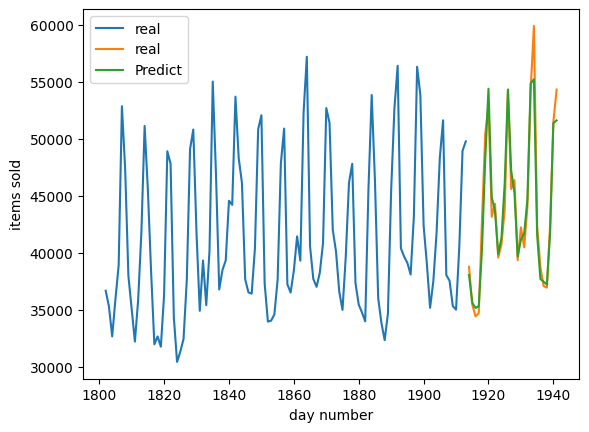

In [ ]:
# 1. All products, all stores, all states (1 series)
all_sales = pd.DataFrame(eval[ts_cols].sum(axis=0)).transpose()
all_sales.index = ['real']

all_sales2 = pd.DataFrame(predict[ts_cols].sum(axis=0)).transpose()
all_sales2.index = ['Predict']

plot_aggregation2(all_sales,all_sales2)



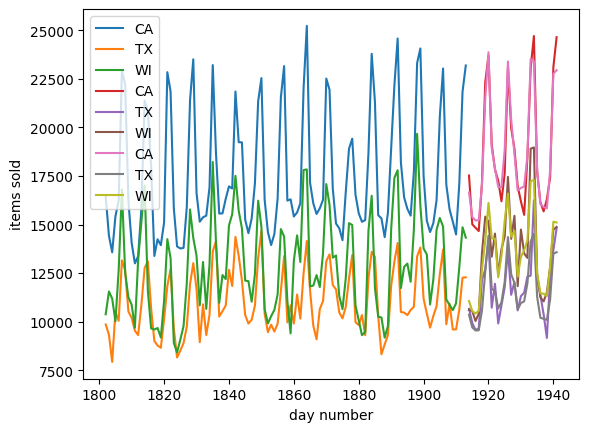

In [ ]:
# 2. All products by state (3 series)
state_sales = eval.groupby('state_id')[ts_cols].sum()
state_sales2 = predict.groupby('state_id')[ts_cols].sum()
plot_aggregation2(state_sales,state_sales2)

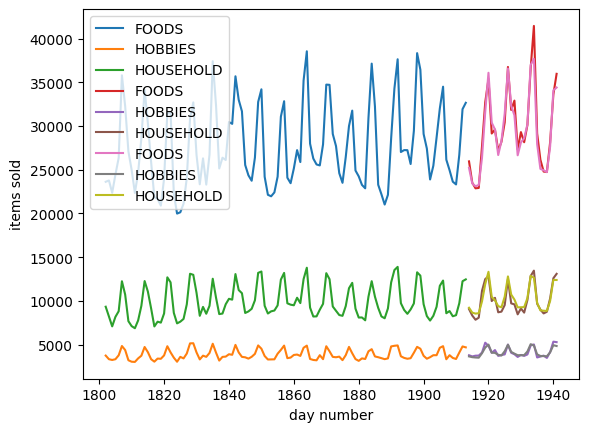

In [ ]:
# 4. All products by category (3 series)
cat_sales = eval.groupby('cat_id')[ts_cols].sum()
cat_sales2 = predict.groupby('cat_id')[ts_cols].sum()
plot_aggregation2(cat_sales,cat_sales2)

In [ ]:
!cp /content/submission.csv /content/drive/MyDrive/Work/Coraline/assignment_test/submission.csv
!cp /content/submission_magic.csv /content/drive/MyDrive/Work/Coraline/assignment_test/submission_magic.csv

# Next Evaluate

In [ ]:
df_calendar = pd.read_csv('/content/calendar.csv')

In [ ]:
h = 28     # day forecast_range
max_lags = 70
tr_last = 1941
fday = datetime(2016,5, 23)
print(fday)
df_calendar.loc[(df_calendar['d']=='d_1942')]

2016-05-23 00:00:00


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1941,2016-05-23,11617,Monday,3,5,2016,d_1942,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
del df_calendar
del df

In [ ]:
CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category",
             "event_type_2": "category", "weekday": "category",
             'wm_yr_wk': 'int16', "wday": "int16","month": "int16", "year": "int16",
             "snap_CA": "float32",'snap_TX': 'float32', 'snap_WI': 'float32' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

In [ ]:
def create_df(trainning = True, first_day = 1200):
    df_prices = pd.read_csv("/content/sell_prices.csv", dtype = PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            df_prices[col] = df_prices[col].cat.codes.astype("int16")
            df_prices[col] -= df_prices[col].min()

    df_cal = pd.read_csv("/content/calendar.csv", dtype = CAL_DTYPES)
    df_cal["date"] = pd.to_datetime(df_cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            df_cal[col] = df_cal[col].cat.codes.astype("int16")
            df_cal[col] -= df_cal[col].min()

    start_day = max(1 if trainning  else tr_last-max_lags, first_day)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols}
    dtype.update({col: "category" for col in catcols if col != "id"})

    df = pd.read_csv("/content/sales_train_evaluation.csv",
                    usecols = catcols + numcols, dtype = dtype)

    for col in catcols:
        if col != "id":
            df[col] = df[col].cat.codes.astype("int16")
            df[col] -= df[col].min()

    if not trainning:
        for day in range(tr_last+1, tr_last+ 28 +1):
            df[f"d_{day}"] = np.nan

    df = pd.melt(df,
                  id_vars = catcols,
                  value_vars = [col for col in df.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")

    df = df.merge(df_cal, on= "d", copy = False)
    df = df.merge(df_prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)

    return df

In [ ]:
def create_fea(df):
    lags = [7,14,28]
    lag_cols = [f"lag_{lag}" for lag in lags]
    for lag, lag_col in (zip(lags, lag_cols)):
        df[lag_col] = df[["id","sales"]].groupby("id")["sales"].shift(lag)

    wins = [7,28]
    for win in (wins) :
        for lag,lag_col in (zip(lags, lag_cols)):
            df[f"rmean_{lag}_{win}"] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())


    date_features = {

        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
    }

#     dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)

    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in df.columns:
            df[date_feat_name] = df[date_feat_name].astype("int16")
        else:
            df[date_feat_name] = getattr(df["date"].dt, date_feat_func).astype("int16")

In [ ]:
%%time
FIRST_DAY = 1000
df = create_df(trainning=True, first_day= FIRST_DAY)
print(df.shape)
df

(27453806, 22)
CPU times: user 23 s, sys: 12.2 s, total: 35.2 s
Wall time: 35.7 s


,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,d_1000,0.0,2013-10-24,11339,4,6,10,2013,0,0,0,0,0.0,0.0,0.0,8.26
1,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,d_1001,2.0,2013-10-25,11339,0,7,10,2013,0,0,0,0,0.0,0.0,0.0,8.26
2,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,d_1000,0.0,2013-10-24,11339,4,6,10,2013,0,0,0,0,0.0,0.0,0.0,3.97
3,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,d_1001,0.0,2013-10-25,11339,0,7,10,2013,0,0,0,0,0.0,0.0,0.0,3.97
4,HOBBIES_1_004_CA_1_evaluation,3,0,0,0,0,d_1000,1.0,2013-10-24,11339,4,6,10,2013,0,0,0,0,0.0,0.0,0.0,4.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27453801,FOODS_3_825_WI_3_evaluation,3046,6,9,2,2,d_1941,2.0,2016-05-22,11617,3,2,5,2016,0,0,0,0,0.0,0.0,0.0,3.98
27453802,FOODS_3_826_WI_3_evaluation,3047,6,9,2,2,d_1940,1.0,2016-05-21,11617,2,1,5,2016,0,0,0,0,0.0,0.0,0.0,1.28
27453803,FOODS_3_826_WI_3_evaluation,3047,6,9,2,2,d_1941,0.0,2016-05-22,11617,3,2,5,2016,0,0,0,0,0.0,0.0,0.0,1.28
27453804,FOODS_3_827_WI_3_evaluation,3048,6,9,2,2,d_1940,5.0,2016-05-21,11617,2,1,5,2016,0,0,0,0,0.0,0.0,0.0,1.00


In [ ]:
%%time
create_fea(df)
print(df.shape)
df

(27453806, 34)
CPU times: user 2min 50s, sys: 16.2 s, total: 3min 7s
Wall time: 3min 8s


,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_14,lag_28,rmean_7_7,rmean_14_7,rmean_28_7,rmean_7_28,rmean_14_28,rmean_28_28,week,quarter,mday
0,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,d_1000,0.0,2013-10-24,11339,4,6,10,2013,0,0,0,0,0.0,0.0,0.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43,4,24
1,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,d_1001,2.0,2013-10-25,11339,0,7,10,2013,0,0,0,0,0.0,0.0,0.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43,4,25
2,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,d_1000,0.0,2013-10-24,11339,4,6,10,2013,0,0,0,0,0.0,0.0,0.0,3.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43,4,24
3,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,d_1001,0.0,2013-10-25,11339,0,7,10,2013,0,0,0,0,0.0,0.0,0.0,3.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43,4,25
4,HOBBIES_1_004_CA_1_evaluation,3,0,0,0,0,d_1000,1.0,2013-10-24,11339,4,6,10,2013,0,0,0,0,0.0,0.0,0.0,4.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43,4,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27453801,FOODS_3_825_WI_3_evaluation,3046,6,9,2,2,d_1941,2.0,2016-05-22,11617,3,2,5,2016,0,0,0,0,0.0,0.0,0.0,3.98,1.0,1.0,0.0,1.142857,0.428571,0.571429,0.714286,0.678571,0.892857,20,2,22
27453802,FOODS_3_826_WI_3_evaluation,3047,6,9,2,2,d_1940,1.0,2016-05-21,11617,2,1,5,2016,0,0,0,0,0.0,0.0,0.0,1.28,1.0,2.0,1.0,1.000000,1.142857,0.857143,1.142857,1.107143,0.964286,20,2,21
27453803,FOODS_3_826_WI_3_evaluation,3047,6,9,2,2,d_1941,0.0,2016-05-22,11617,3,2,5,2016,0,0,0,0,0.0,0.0,0.0,1.28,1.0,1.0,3.0,1.000000,1.285714,1.142857,1.142857,1.071429,0.928571,20,2,22
27453804,FOODS_3_827_WI_3_evaluation,3048,6,9,2,2,d_1940,5.0,2016-05-21,11617,2,1,5,2016,0,0,0,0,0.0,0.0,0.0,1.00,2.0,2.0,0.0,0.714286,1.428571,0.000000,0.571429,0.392857,1.250000,20,2,21


In [ ]:
df.dropna(inplace = True)
print(df.shape)

df=downcast(df)
df.info()

(25776856, 34)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25776856 entries, 1309472 to 27453805
Data columns (total 34 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       int16         
 2   dept_id       int8          
 3   store_id      int8          
 4   cat_id        int8          
 5   state_id      int8          
 6   d             category      
 7   sales         float16       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int8          
 11  wday          int8          
 12  month         int8          
 13  year          int16         
 14  event_name_1  int8          
 15  event_type_1  int8          
 16  event_name_2  int8          
 17  event_type_2  int8          
 18  snap_CA       float16       
 19  snap_TX       float16       
 20  snap_WI       float16       
 21  sell_price    float16       
 22  lag_7         float16       
 23  lag_14   

In [ ]:
df.tail()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_14,lag_28,rmean_7_7,rmean_14_7,rmean_28_7,rmean_7_28,rmean_14_28,rmean_28_28,week,quarter,mday
27453801,FOODS_3_825_WI_3_evaluation,3046,6,9,2,2,d_1941,2.0,2016-05-22,11617,3,2,5,2016,0,0,0,0,0.0,0.0,0.0,3.980469,1.0,1.0,0.0,1.142578,0.428467,0.571289,0.714355,0.678711,0.893066,20,2,22
27453802,FOODS_3_826_WI_3_evaluation,3047,6,9,2,2,d_1940,1.0,2016-05-21,11617,2,1,5,2016,0,0,0,0,0.0,0.0,0.0,1.280273,1.0,2.0,1.0,1.000000,1.142578,0.856934,1.142578,1.107422,0.964355,20,2,21
27453803,FOODS_3_826_WI_3_evaluation,3047,6,9,2,2,d_1941,0.0,2016-05-22,11617,3,2,5,2016,0,0,0,0,0.0,0.0,0.0,1.280273,1.0,1.0,3.0,1.000000,1.286133,1.142578,1.142578,1.071289,0.928711,20,2,22
27453804,FOODS_3_827_WI_3_evaluation,3048,6,9,2,2,d_1940,5.0,2016-05-21,11617,2,1,5,2016,0,0,0,0,0.0,0.0,0.0,1.000000,2.0,2.0,0.0,0.714355,1.428711,0.000000,0.571289,0.392822,1.250000,20,2,21
27453805,FOODS_3_827_WI_3_evaluation,3048,6,9,2,2,d_1941,1.0,2016-05-22,11617,3,2,5,2016,0,0,0,0,0.0,0.0,0.0,1.000000,0.0,1.0,0.0,0.571289,1.428711,0.000000,0.571289,0.428467,1.071289,20,2,22


In [ ]:
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
train_cols = df.columns[~df.columns.isin(useless_cols)]
X_train = df[train_cols]
y_train = df["sales"]

In [ ]:
train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=cat_feats, free_raw_data=False)
fake_valid_inds = np.random.choice(len(X_train), 1000000)
fake_valid_data = lgb.Dataset(X_train.iloc[fake_valid_inds], label = y_train.iloc[fake_valid_inds],categorical_feature=cat_feats,
                             free_raw_data=False)   # This is just a subsample of the training set, not a real validation set !

In [ ]:
params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        "metric": ["rmse"],
        'verbosity': 1,
        'num_iterations' : 2500,

}

In [ ]:
%%time
m_lgb = lgb.train(params, train_data, valid_sets = [fake_valid_data], verbose_eval=100)

[LightGBM] [Info] Total Bins 5209
[LightGBM] [Info] Number of data points in the train set: 25776856, number of used features: 28
[LightGBM] [Info] Start training from score 0.244536
[100]	valid_0's rmse: 2.30162
[200]	valid_0's rmse: 2.25998
[300]	valid_0's rmse: 2.23655
[400]	valid_0's rmse: 2.21461
[500]	valid_0's rmse: 2.19748
[600]	valid_0's rmse: 2.18373
[700]	valid_0's rmse: 2.17166
[800]	valid_0's rmse: 2.16173
[900]	valid_0's rmse: 2.15345
[1000]	valid_0's rmse: 2.14386
[1100]	valid_0's rmse: 2.13618
[1200]	valid_0's rmse: 2.12749
[1300]	valid_0's rmse: 2.11961
[1400]	valid_0's rmse: 2.11298
[1500]	valid_0's rmse: 2.10387
[1600]	valid_0's rmse: 2.09906
[1700]	valid_0's rmse: 2.09171
[1800]	valid_0's rmse: 2.08689
[1900]	valid_0's rmse: 2.08298
[2000]	valid_0's rmse: 2.07551
[2100]	valid_0's rmse: 2.07142
[2200]	valid_0's rmse: 2.06496
[2300]	valid_0's rmse: 2.06089
[2400]	valid_0's rmse: 2.05685
[2500]	valid_0's rmse: 2.0522
CPU times: user 3h 43min 23s, sys: 22.4 s, total: 3h

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

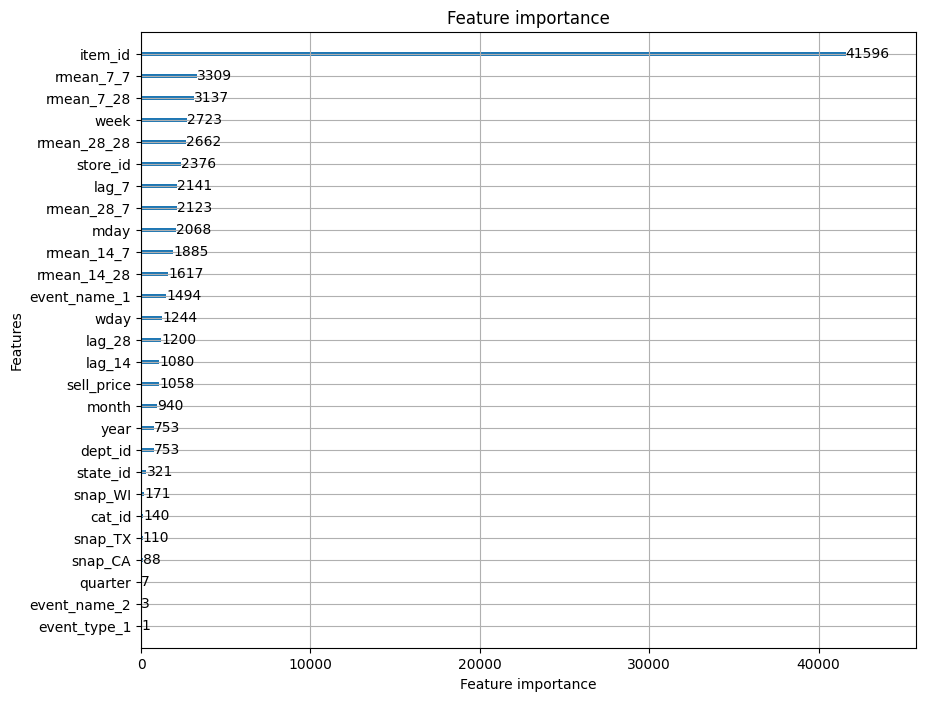

In [ ]:
lgb.plot_importance(m_lgb, figsize=(10,8))

## **Forecast d_1942 - d_1970 (normal)**

In [ ]:
%%time

alphas = [1]
weights = [1/len(alphas)]*len(alphas)
sub = 0.

for icount, (alpha, weight) in enumerate(zip(alphas, weights)):

    te = create_df(False)
    cols = [f"F{i}" for i in range(1,29)]

    for tdelta in trange(0, 28):
        day = fday + timedelta(days=tdelta)
        print(icount, day)
        tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
        create_fea(tst)
        tst = tst.loc[tst.date == day , train_cols]
        te.loc[te.date == day, "sales"] = alpha*m_lgb.predict(tst) # magic multiplier



    te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()
    te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
    te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
    te_sub.fillna(0., inplace = True)
    te_sub.sort_values("id", inplace = True)
    te_sub.reset_index(drop=True, inplace = True)
#     te_sub.to_csv("submission.csv",index=False)
    if icount == 0 :
        sub = te_sub
        sub[cols] *= weight
    else:
        sub[cols] += te_sub[cols]*weight
    print(icount, alpha, weight)


sub2 = sub.copy()
sub2["id"] = sub2["id"].str.replace("evaluation$", "validation")
sub = pd.concat([sub, sub2], axis=0, sort=False)
sub.to_csv("submission.csv",index=False)

  0%|          | 0/28 [00:00<?, ?it/s]

0 2016-05-23 00:00:00
0 2016-05-24 00:00:00
0 2016-05-25 00:00:00
0 2016-05-26 00:00:00
0 2016-05-27 00:00:00
0 2016-05-28 00:00:00
0 2016-05-29 00:00:00
0 2016-05-30 00:00:00
0 2016-05-31 00:00:00
0 2016-06-01 00:00:00
0 2016-06-02 00:00:00
0 2016-06-03 00:00:00
0 2016-06-04 00:00:00
0 2016-06-05 00:00:00
0 2016-06-06 00:00:00
0 2016-06-07 00:00:00
0 2016-06-08 00:00:00
0 2016-06-09 00:00:00
0 2016-06-10 00:00:00
0 2016-06-11 00:00:00
0 2016-06-12 00:00:00
0 2016-06-13 00:00:00
0 2016-06-14 00:00:00
0 2016-06-15 00:00:00
0 2016-06-16 00:00:00
0 2016-06-17 00:00:00
0 2016-06-18 00:00:00
0 2016-06-19 00:00:00
0 1 1.0
CPU times: user 44min 43s, sys: 22.5 s, total: 45min 5s
Wall time: 42min 21s


In [ ]:
!kaggle competitions submit -c m5-forecasting-accuracy -f /content/submission.csv -m "Message"

100% 32.7M/32.7M [00:04<00:00, 8.47MB/s]
Successfully submitted to M5 Forecasting - Accuracy

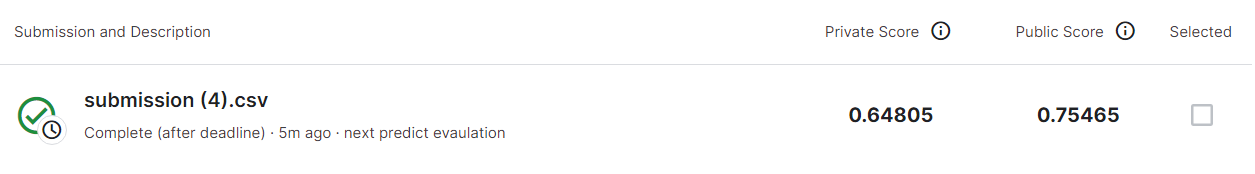

Predict only d_1942 - d_1970 for valuation **(corresponding to the Private leaderboard)**

> Private Score 0.64805

## **Forecast d_1942 - d_1970 (Magic multiplier by Konthee)**

In [ ]:
%%time

# alphas = [1.035, 1.03, 1.025, 1.02]
alphas = [0.965, 0.97, 0.975, 0.98]   # -> downtrend Magic Multiplier
weights = [1/len(alphas)]*len(alphas)
sub = 0.

for icount, (alpha, weight) in enumerate(zip(alphas, weights)):

    te = create_df(False)
    cols = [f"F{i}" for i in range(1,29)]

    for tdelta in trange(0, 28):
        day = fday + timedelta(days=tdelta)
        print(icount, day)
        tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
        create_fea(tst)
        tst = tst.loc[tst.date == day , train_cols]
        te.loc[te.date == day, "sales"] = alpha*m_lgb.predict(tst) # magic multiplier



    te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()
    te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
    te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
    te_sub.fillna(0., inplace = True)
    te_sub.sort_values("id", inplace = True)
    te_sub.reset_index(drop=True, inplace = True)
#     te_sub.to_csv("submission.csv",index=False)
    if icount == 0 :
        sub = te_sub
        sub[cols] *= weight
    else:
        sub[cols] += te_sub[cols]*weight
    print(icount, alpha, weight)


sub2 = sub.copy()
sub2["id"] = sub2["id"].str.replace("evaluation$", "validation")
sub = pd.concat([sub, sub2], axis=0, sort=False)
sub.to_csv("submission_magic2.csv",index=False)

  0%|          | 0/28 [00:00<?, ?it/s]

0 2016-05-23 00:00:00
0 2016-05-24 00:00:00
0 2016-05-25 00:00:00
0 2016-05-26 00:00:00
0 2016-05-27 00:00:00
0 2016-05-28 00:00:00
0 2016-05-29 00:00:00
0 2016-05-30 00:00:00
0 2016-05-31 00:00:00
0 2016-06-01 00:00:00
0 2016-06-02 00:00:00
0 2016-06-03 00:00:00
0 2016-06-04 00:00:00
0 2016-06-05 00:00:00
0 2016-06-06 00:00:00
0 2016-06-07 00:00:00
0 2016-06-08 00:00:00
0 2016-06-09 00:00:00
0 2016-06-10 00:00:00
0 2016-06-11 00:00:00
0 2016-06-12 00:00:00
0 2016-06-13 00:00:00
0 2016-06-14 00:00:00
0 2016-06-15 00:00:00
0 2016-06-16 00:00:00
0 2016-06-17 00:00:00
0 2016-06-18 00:00:00
0 2016-06-19 00:00:00
0 0.965 0.25


  0%|          | 0/28 [00:00<?, ?it/s]

1 2016-05-23 00:00:00
1 2016-05-24 00:00:00
1 2016-05-25 00:00:00
1 2016-05-26 00:00:00
1 2016-05-27 00:00:00
1 2016-05-28 00:00:00
1 2016-05-29 00:00:00
1 2016-05-30 00:00:00
1 2016-05-31 00:00:00
1 2016-06-01 00:00:00
1 2016-06-02 00:00:00
1 2016-06-03 00:00:00
1 2016-06-04 00:00:00
1 2016-06-05 00:00:00
1 2016-06-06 00:00:00
1 2016-06-07 00:00:00
1 2016-06-08 00:00:00
1 2016-06-09 00:00:00
1 2016-06-10 00:00:00
1 2016-06-11 00:00:00
1 2016-06-12 00:00:00
1 2016-06-13 00:00:00
1 2016-06-14 00:00:00
1 2016-06-15 00:00:00
1 2016-06-16 00:00:00
1 2016-06-17 00:00:00
1 2016-06-18 00:00:00
1 2016-06-19 00:00:00
1 0.97 0.25


  0%|          | 0/28 [00:00<?, ?it/s]

2 2016-05-23 00:00:00
2 2016-05-24 00:00:00
2 2016-05-25 00:00:00
2 2016-05-26 00:00:00
2 2016-05-27 00:00:00
2 2016-05-28 00:00:00
2 2016-05-29 00:00:00
2 2016-05-30 00:00:00
2 2016-05-31 00:00:00
2 2016-06-01 00:00:00
2 2016-06-02 00:00:00
2 2016-06-03 00:00:00
2 2016-06-04 00:00:00
2 2016-06-05 00:00:00
2 2016-06-06 00:00:00
2 2016-06-07 00:00:00
2 2016-06-08 00:00:00
2 2016-06-09 00:00:00
2 2016-06-10 00:00:00
2 2016-06-11 00:00:00
2 2016-06-12 00:00:00
2 2016-06-13 00:00:00
2 2016-06-14 00:00:00
2 2016-06-15 00:00:00
2 2016-06-16 00:00:00
2 2016-06-17 00:00:00
2 2016-06-18 00:00:00
2 2016-06-19 00:00:00
2 0.975 0.25


  0%|          | 0/28 [00:00<?, ?it/s]

3 2016-05-23 00:00:00
3 2016-05-24 00:00:00
3 2016-05-25 00:00:00
3 2016-05-26 00:00:00
3 2016-05-27 00:00:00
3 2016-05-28 00:00:00
3 2016-05-29 00:00:00
3 2016-05-30 00:00:00
3 2016-05-31 00:00:00
3 2016-06-01 00:00:00
3 2016-06-02 00:00:00
3 2016-06-03 00:00:00
3 2016-06-04 00:00:00
3 2016-06-05 00:00:00
3 2016-06-06 00:00:00
3 2016-06-07 00:00:00
3 2016-06-08 00:00:00
3 2016-06-09 00:00:00
3 2016-06-10 00:00:00
3 2016-06-11 00:00:00
3 2016-06-12 00:00:00
3 2016-06-13 00:00:00
3 2016-06-14 00:00:00
3 2016-06-15 00:00:00
3 2016-06-16 00:00:00
3 2016-06-17 00:00:00
3 2016-06-18 00:00:00
3 2016-06-19 00:00:00
3 0.98 0.25
CPU times: user 3h 37s, sys: 1min 41s, total: 3h 2min 19s
Wall time: 2h 50min 34s


In [ ]:
!kaggle competitions submit -c m5-forecasting-accuracy -f /content/submission_magic2.csv -m "Magic multiplier reduce"

100% 32.7M/32.7M [00:05<00:00, 6.39MB/s]
Successfully submitted to M5 Forecasting - Accuracy

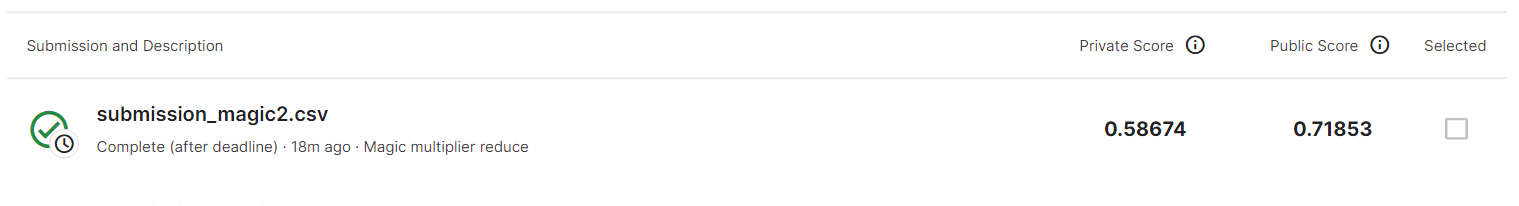

Predict only d_1942 - d_1970 for valuation **(corresponding to the Private leaderboard)**

> Private Score 0.58674  


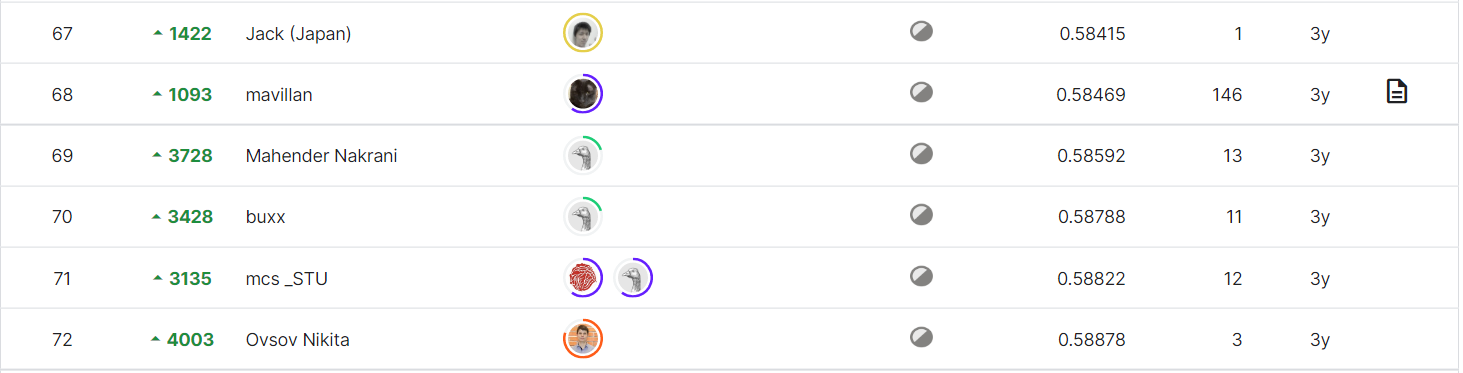